# Pic2Speech - A Neural Image Captioning Model
In this Notebook we are going to create a Neural Image Captioning Model. Our model will be able to generate a description for a given picture. After building the model we will deploy it to a Web Service using Azure Machine Learning service and we will use it from a mobile app. I called the app Pic2Speech and it's purpose is to help visually impaired understanding the world, describing the content of pictures taken with smartphone's camera through a TTS (Text To Speech) synthesizer. The app is fully Open Source and it's available for download on [Google Play](https://play.google.com/store/apps/details?id=gfg.app.pictospeech).

## The Dataset
The dataset we will use to train our model is the MS COCO 2019 Dataset. This dataset contains 82783 pictures with 5 human generated captions each. Let's download the full dataset from its orignal repository and extract the zip archives with unzip.

In [0]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!wget http://images.cocodataset.org/zips/train2014.zip
  
!unzip -q annotations_trainval2014.zip
!unzip -q train2014.zip

replace annotations/instances_train2014.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
replace train2014/COCO_train2014_000000270070.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Inside *annotations* directory we can find a JSON file called *captions_train2014.json*, it contains all the captions in the following format:
<br><br>
*{<br>
&nbsp;"annotations": <br>
&nbsp; { <br>
&emsp;"image_id": IMAGE_ID, <br>
&emsp;"caption": CAPTION} <br>
&nbsp;},<br>
&nbsp;...<br>
}*

Where IMAGE_ID is the id of the image to which the caption refers and CAPTION is the caption. Inside the folder train2014 we can find the actual images in jpg format, image are named with this standard
<br><br>
*COCO_train2014_**IMAGE_ID**.jpg*
<br><br>
in this case IMAGE_ID is always a 14 characters long string where the last characters are the actual IMAGE_ID and all the others are 0. For example, an IMAGE_ID of 317672 in captions_train2014.json will refer to the image *COCO_train2014_0000000317672.jpg*.


## The Model
The model we are going to build is mostly based on the paper "Show and Tell: A Neural Image Caption Generator" by Vinyals et al [(1)](#references). The model consists of:
* A Deep Convolutional Neural Network used to encode the image in lower dimensional space.
* A Language Generating-Recurrent Neural Network that take in input the encoded image and generate a caption for it using the sampling tecnique, where we sample the next word until we get the end of sequence character or until we reach the maximum length for a caption.
<br><br>
<img src="https://github.com/gfgullo/Pic2Speech/raw/master/jupyter%20notebooks/res/nicm_1.png"/>
<p align="center">Image from <a href="https://arxiv.org/pdf/1411.4555.pdf" target="_blank">Show and Tell: A Neural Image Caption Generator</a> by Vinyals et al</p>

## Dependencies
We will create the model using **Keras** on top of **Tensorflow 1.14**, we will also use some scikit-learn's functions for data preprocessing and model selection. We will use **BLEU (2)** for model evaluation, a scoring method mostly used in Machine Translation that will fit good also for our purpose, we will use it through **NLTK**.

In [0]:
import numpy as np

import json
import string
import pickle
import os
from time import time
from random import randint

from PIL import Image

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Model

from keras.applications.inception_v3 import InceptionV3, preprocess_input

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.utils import to_categorical

from keras.layers import Input, Dropout, Embedding, LSTM, Dense
from keras.layers.merge import add

from keras.callbacks import LambdaCallback, EarlyStopping, ModelCheckpoint, LearningRateScheduler

from keras.optimizers import Adam

from nltk.translate.bleu_score import corpus_bleu

from IPython.display import display

Using TensorFlow backend.


## Preprocess the Text
Let's begin preprocessing all the captions. We can limit the number of images we want use to train our model putting the number inside *img_count*, this could be useful if we don't have enough computing capability to train the model on the entire dataset. Of course the more samples we use the better the model's quality we can achieve. If you want to train the model on the entire dataset just put None.<br>
We will process every caption applying the following transformations:
* Convert the entire string to lower case.
* Remove all punctuation from the string.
* Add string delimiters using *startseq* and *endseq*, we have to do this because our model need to know when a caption end and when the next begin.

We will save captions in a dictionary where the key is the image id.

In [0]:
CAPTIONS_FILE = "annotations/captions_train2014.json"

imgs_count = None # use this variable to limit the number of samples

img_captions = {}

with open(CAPTIONS_FILE) as captions_file:
  
  captions_json = json.loads(captions_file.read())
  
  for caption in captions_json["annotations"]:
        
    caption_text = caption["caption"]
    caption_text = caption_text.lower() # convert the text in lowercase
    caption_text = caption_text.translate(str.maketrans('', '', string.punctuation)) # remove punctuation
    caption_text = "startseq "+caption_text+" endseq" # add start and end of sequence delimiter
    
    img_id = caption["image_id"]

    if(img_id in img_captions):
      img_captions[img_id].append(caption_text)
    else:
      img_captions[img_id] = [caption_text]
      if(imgs_count!=None):
        imgs_count-=1
        if(imgs_count <= 0):
          break

len(img_captions)

1000

Now we can use the dictionary to create two separated lists for images id and for captions, in this way all the captions that refers to the same image will be close to each other in the lists. This is important because, by doing this, when we split the sets for train and test, we will be sure that images that will be used for test aren't also in the train set, so the evaluation on the test set will be much more reliable. Of course to train the model we have to shuffle the train set, but we can do this later.

In [0]:
captions_text, captions_img = [], []

for img_id in img_captions:
  for caption in img_captions[img_id]:
    captions_img.append(img_id)
    captions_text.append(caption)

print(captions_text[:20])
print(captions_img[:20])

['startseq a very clean and well decorated empty bathroom endseq', 'startseq a blue and white bathroom with butterfly themed wall tiles endseq', 'startseq a bathroom with a border of butterflies and blue paint on the walls above it endseq', 'startseq an angled view of a beautifully decorated bathroom endseq', 'startseq a clock that blends in with the wall hangs in a bathroom  endseq', 'startseq a panoramic view of a kitchen and all of its appliances endseq', 'startseq a panoramic photo of a kitchen and dining room endseq', 'startseq a wide angle view of the kitchen work area endseq', 'startseq multiple photos of a brown and white kitchen  endseq', 'startseq a graffitied stop sign across the street from a red car  endseq', 'startseq a vandalized stop sign and a red beetle on the road endseq', 'startseq a red stop sign with a bush bumper sticker under the word stop endseq', 'startseq a stop sign that has been vandalized is pictured in front of a parked car endseq', 'startseq a street sig

## Load the Image Encoder

Let's move to images. We will enconde every image in a 2048 vectors' space using the **InceptionV3 model (3)**. We can load the model pretrained on the **ImageNet (4)** using Keras. Since we want to encode the images and not recognize their content we will remove the output layer from the model. 

In [0]:
HEIGHT = 299
WIDTH = 299
OUTPUT_DIM = 2048

encode_model = InceptionV3(weights='imagenet') # load the model
encode_model = Model(encode_model.input, encode_model.layers[-2].output) # remove the output layer

W0902 09:48:29.731345 140260037138304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0902 09:48:29.765951 140260037138304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0902 09:48:29.778274 140260037138304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0902 09:48:29.814051 140260037138304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0902 09:48:29.815017 1402600371

96116736/96112376 [==============================] - 3s 0us/step


## Preprocess the Images
To preprocess the image we will load each image in a loop, resizing it to match the input size of 299x299 required by the Inception V3 model and feeding it to the model, then we will save the output inside a dictionary, where the key is again the image id. Since this process could take a long time (depending on your hardware and on the dataset's size) we will dump the dictionary on a local file using **pickle**, so the next time we can load this file instead of preprocessing again every image.

In [0]:
ENCODED_IMGS_FILE = "features.pkl"

if(os.path.exists(ENCODED_IMGS_FILE)):
  
  with open(ENCODED_IMGS_FILE,"rb") as handle:
    encoded_imgs = pickle.load(handle)

else:

  IMG_PATH = "train2014/"

  imgs_id = set(captions_img)
  encoded_imgs = {}

  for i, img_id in enumerate(imgs_id):

    img_file = 'COCO_train2014_' + '%012d.jpg' % img_id
    img = load_img(IMG_PATH+img_file)
    img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)  
    arr = img_to_array(img)

    x = preprocess_input(arr)
    x = np.expand_dims(x, axis=0)

    features = encode_model.predict(x)
    features = np.reshape(features, OUTPUT_DIM)

    encoded_imgs[img_id]=features

    with open(ENCODED_IMGS_FILE,"wb") as handle:
      pickle.dump(encoded_imgs ,handle)      

## Create the Train, Test and Validation Set

In [0]:
captions_text_train, captions_text_test, captions_img_train, captions_img_test = train_test_split(captions_text, captions_img, test_size=0.05, random_state=0)

print("Sample in Train Set: %d " % len(captions_text_train))
print("Sample in Test Set: %d " % len(captions_text_test))

Sample in Train Set: 4229 
Sample in Test Set: 223 


## Create the Tokenizer
It's time for tokenization ! This process consists in splitting the text in its constituent parts, called tokens. Many words in our text corpus can be very rare and such words will bring just noise to our model. So let's take only the words which appear at least 5 times in the entire text corpus. Define a function to get the vocabulary and another function to count the number of words that appear at least 5 times.

In [0]:
def get_vocab(captions):
  
  vocab = {}
  
  for caption in captions:
    words = caption.split()
    
    for word in words:
      
      if(word in vocab):
        vocab[word]+=1
      else:
        vocab[word]=1
   
  return vocab


def count_top_words(captions, min_count=5):
  
  vocab = get_vocab(captions)
  top_words = 0
    
  for word in vocab:
    
    if(vocab[word]>min_count):
      top_words+=1
      
  return top_words
  
  
VOCAB_SIZE = count_top_words(captions_text)
print("Size of Corpus Vocabulary: %d " % VOCAB_SIZE)

698


Now we can use the Keras' Tokenizer class to perform tokenization on both train and test set, giving the vocabulary size with the *num_words* param.

In [0]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(captions_text)

sequences_train = tokenizer.texts_to_sequences(captions_text_train)
sequences_test = tokenizer.texts_to_sequences(captions_text_test)

How long is the longest caption in the train set ? To build our model we need this information, let's get it.

In [0]:
MAX_LEN = max(len(tokens) for tokens in sequences_train)
print("Length of the longest caption in train set: %d " % MAX_LEN)

28


## Build a Generator

Great ! We are almost done with data preprocessing, last steps are:
* Create sequences of data, where, for each word in each caption, we will create a sequence with the word as target and all previous words as features.
* We pad each features sequence to make every sequence the same length.
* We create dummy variables for targets using One Hot Encoding.

But there is an huge problem in the last step if we use the full dataset, in this case the resulting array will get really big. How big ?
* We have 393407 captions in our train set, let's say that a caption is 10 words long in average plus the delimiters startseq and endseq, so we will we have 11 sequences for caption, we also have 8103 in our vocabulary, this means that the array containing encoded targets with One Hot Encoding will weight
<br><br>
  *393407 x 11 x 8103 x 4 = 140262184524 bytes ≈ 140 Gigabytes*
<br><br>
I multiplied by 4 because Keras uses float for One Hot Encoding, this is really too  much for my little tiny RAM. 
<br><br>
What can we do ? A good solution is to use a generator and create our train samples on the fly during training, this will make the training time much longer but will save our RAM.<br>
<br>
Now it's also time to shuffle our sets, we will do this at every epoch.

In [0]:
def create_sequence(seq, caption_img, max_length, vocab_size):
  
  x1, x2, y = [], [], []

    
  for i in range(len(seq)-1):
    x1.append(encoded_imgs[caption_img])
    x2.append(pad_sequences([seq[:i+1]], maxlen=max_length)[0]) # pad the sequence
    y.append(to_categorical([seq[i+1]], num_classes=vocab_size)[0]) # perform one hot encoding  
      
  return x1, x2, y


def data_generator(sequences, captions_img, max_length, vocab_size, batch_size=None):
 
  tot_samples = len(sequences)
  
  if(batch_size==None):
    batch_size=tot_samples
  
  n_batches = int(tot_samples/batch_size)
  
  while 1:
    
    batch_start = 0
    sequences, captions_img = shuffle(sequences, captions_img) # time to shuffle 
    
    
    for _ in range(n_batches):
            
      X1, X2, Y = [], [], [] 
      
      batch_end = batch_start+batch_size
            
      if(batch_end>tot_samples):
        batch_end = tot_samples
        
      sequences_batch = sequences[batch_start:batch_end] 
      captions_img_batch = captions_img[batch_start:batch_end]     
                
      for seq, caption_img in zip(sequences_batch, captions_img_batch):
        
        x1, x2, y = create_sequence(seq, caption_img, max_length, vocab_size)
        
        if(len(X1)==0):
          X1, X2, Y = x1, x2, y
        else:
          X1, X2, Y = X1+x1, X2+x2, Y+y

      batch_start+=batch_size
        
      yield [[np.array(X1), np.array(X2)],np.array(Y)]      

## Create the Embedding

We can start building our Model ! The first layer of our Neural Network will perform Words Embedding (5), that will encode words in a N-dimensional vectors' space where related words are close. We will use a pretrained Word Embedding Model, the GloVe Model (6). Download the model and unzip it.

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2019-09-02 09:54:04--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-09-02 09:54:04--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2019-09-02 09:54:05--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We got 4 files with different vectors' space: 50, 100, 200 and 300. For our model we will use the 100d embedding. For every row in the file we have the word and then the embedding values separated by spaces. Let's define a function to load the embedding inside a dictionary, where the key is the corresponding word.

In [0]:
def load_embedding(filename):
  
  with open(filename) as file:
    lines = file.readlines()

  embedding = dict()
  
  for line in lines:
    parts = line.split()
    embedding[parts[0]] = np.asarray(parts[1:])
    
  return embedding

raw_embedding = load_embedding('glove.6B.100d.txt')

Now we can use the embedding dictionary to build an embedding weight matrix for our text corpus, let's define another function for this.

In [0]:
def get_weight_matrix(embedding, index_word, vocab_size):
    
  weight_matrix = np.zeros((vocab_size, 100))

  for i in range(vocab_size):
    word = index_word[i+1]
    vector = embedding.get(word)
    if vector is not None:
      weight_matrix[i] = vector
      
  return weight_matrix

embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.index_word, VOCAB_SIZE)
embedding_vectors.shape

(698, 100)

## Buld the Neural Network
Time to build the Neural Nework ! Let's define it's architecture using Keras' Functional API. Our Neural Nework has two inputs, the 2048 dimensions encoded image and the text-emcpded sequence. It's pretty easy to overfit for such problem, so we will use Dropout to reduce the risk of overfitting. We don't want to change the weights of our embedding layer during training, so we will set the *trainable* parameters to false.

In [0]:
EMBEDDING_DIM = 100

inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(MAX_LEN,))
se1 = Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True, weights=[embedding_vectors], trainable=False)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Great, we can compile the model now, since this is a Multi-class Classification problem we will use Categorical Crossentropy as Loss Function and **ADAM (7)** as optimization algorithm, which should perform better than a simple Stochastic Gradient Descent.

In [0]:
caption_model.compile(loss='categorical_crossentropy', optimizer="adam")

## Fit and Evaluate with Generators
Before starting training we define some callbacks that Keras will execute after each epoch. On the first callback we will call a custom function that will generate a caption for a picture randomly picked from the test set. First define the function to generate the caption, using the sampling technique:
1. Provide the image and the *start of sequence* delimiter as input to the network.
2. Sample from the output the word with the highest probability.
3. Add the word sampled to the sequence and use this as new input for the network together with the image.
4. Repeat step 2 and 3 until sampling the *end of sequence* delimiter or until the maximum length for the caption has been reached.

Let's do it !

In [0]:
def generate_caption(x1):
  
  caption = "startseq"
          
  for i in range(MAX_LEN):
    
    seq = tokenizer.texts_to_sequences([caption])
        
    x2 = pad_sequences(seq, maxlen=MAX_LEN)
        
    y = caption_model.predict([x1,x2], verbose=0)
    word = tokenizer.index_word[np.argmax(y)]
        
    caption+=" "+word
    
    if word == "endseq":
      break

  return caption


And then define the callback function and create the callback

In [0]:
def caption_on_epoch(epoch, _):
  
  test_sample = randint(0, len(captions_img_test)-1)

  x1 = encoded_imgs[captions_img_test[test_sample]]
  x1 = np.expand_dims(x1, axis=0)

  print("GENERATED CAPTION: "+generate_caption(x1))
  print("REFERENCE CAPTION: "+captions_text_test[test_sample])
  
epoch_end_callback = LambdaCallback(on_epoch_end=caption_on_epoch)

Define a second callback that will perform early stopping if the log loss on the validation set doesn't improve at least of 0.001 in 5 epochs.

In [0]:
earlyStopping = EarlyStopping(min_delta=0.001, patience=5)

And two more callbaks to backup our model, one will store our model after each epoch and the other will save only the best model, that is the model that got the lowest loss on the validation set.

In [0]:
lastModelCheckpoint = ModelCheckpoint("caption_model.h5")
bestModelCheckpoint = ModelCheckpoint("best_caption_model.h5", save_best_only=True)

We can now star training for 20 epochs with 32 samples for every step. 

In [0]:
BATCH_SIZE = 32

generator_train = data_generator(sequences_train, captions_img_train, MAX_LEN, VOCAB_SIZE, batch_size=BATCH_SIZE)
generator_test = data_generator(sequences_test, captions_img_test, MAX_LEN, VOCAB_SIZE, batch_size=BATCH_SIZE)

caption_model.fit_generator(generator_train, epochs=20, steps_per_epoch=len(captions_text_train)//BATCH_SIZE, 
                            validation_data= generator_test, validation_steps=len(captions_text_test)//BATCH_SIZE,
                            callbacks=[earlyStopping, epoch_end_callback, lastModelCheckpoint, bestModelCheckpoint])

Epoch 1/20
132/132 [==============================] - 19s 143ms/step - loss: 4.4173 - val_loss: 3.9421
GENERATED CAPTION: startseq a a a a a a a a a a endseq
REFERENCE CAPTION: startseq a man sits at a park with his bike endseq
Epoch 2/20
132/132 [==============================] - 15s 117ms/step - loss: 3.7612 - val_loss: 3.4713
GENERATED CAPTION: startseq a woman with a bench on a endseq
REFERENCE CAPTION: startseq a closeup of a young person holding a tennis racket endseq
Epoch 3/20
132/132 [==============================] - 15s 117ms/step - loss: 3.4124 - val_loss: 3.2248
GENERATED CAPTION: startseq a bathroom with a sink and a sink endseq
REFERENCE CAPTION: startseq the framed picture shows a large tidy kitchen endseq
Epoch 4/20
132/132 [==============================] - 15s 117ms/step - loss: 3.1789 - val_loss: 3.0687
GENERATED CAPTION: startseq a man riding a bike with a bicycle endseq
REFERENCE CAPTION: startseq two adults and a child riding bicycles on the side of a road endseq

Let's execute 10 more epochs on 64 sample per step, lowering the learning rate at 0.0001, this makes sense since when we are close to the minimum we want to take smaller steps.

In [0]:
#caption_model.optimizer.lr = 1e-4
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')
caption_model.optmizer = Adam(lr=1e-4)

BATCH_SIZE = 64

generator_train = data_generator(sequences_train, captions_img_train, MAX_LEN, VOCAB_SIZE, batch_size=BATCH_SIZE)
generator_test = data_generator(sequences_test, captions_img_test, MAX_LEN, VOCAB_SIZE, batch_size=BATCH_SIZE)

caption_model.fit_generator(generator_train, epochs=10, steps_per_epoch=len(captions_text_train)//BATCH_SIZE, 
                            validation_data= generator_test, validation_steps=len(captions_text_test)//BATCH_SIZE,
                            callbacks=[earlyStopping, epoch_end_callback, lastModelCheckpoint, bestModelCheckpoint])

Epoch 1/10
66/66 [==============================] - 13s 193ms/step - loss: 1.8312 - val_loss: 2.7596
GENERATED CAPTION: startseq a scooter parked by a scooter with a in the background endseq
REFERENCE CAPTION: startseq there are scooters and bicycles parked by a wall endseq
Epoch 2/10
66/66 [==============================] - 9s 141ms/step - loss: 1.7490 - val_loss: 2.7287
GENERATED CAPTION: startseq a bathroom with a toilet and a sink endseq
REFERENCE CAPTION: startseq an empty bathroom with a sink and toilette underneath a hand drying towel endseq
Epoch 3/10
66/66 [==============================] - 9s 140ms/step - loss: 1.7176 - val_loss: 2.7907
GENERATED CAPTION: startseq a woman sitting in a car with a black and white cat endseq
REFERENCE CAPTION: startseq a lady driving her car with a black and white cat in her lap endseq
Epoch 4/10
66/66 [==============================] - 9s 141ms/step - loss: 1.6891 - val_loss: 2.8145
GENERATED CAPTION: startseq a person holding a baby on a bed e

Our model is ready ! Let's compute the log loss on the test set.

In [0]:
generator_test = data_generator(sequences_test, captions_img_test, MAX_LEN, VOCAB_SIZE, batch_size=1)
caption_model.evaluate_generator(generator_test, steps=len(sequences_test))

2.8195897356507285

This metric doesn't help so much, because our goal isn't to predict the exact word for each caption but to generate a caption that could generally describe the content of the image. We can use a better metric for this, the BLEU.

## Evaluate with the BLEU Score

The BLEU (2), which stand for Bilingual Evaluation Understudy, is a evaluation metric popular in the field on Machine Translation but it can be used to evaluate every kind of text generated tasks.

In [0]:
generated_captions = []
reference_captions = []

for img_id in captions_img_test:
  x1 = encoded_imgs[img_id]
  x1 = np.expand_dims(x1, axis=0)
  generated_captions.append(generate_caption(x1))
  reference_captions.append([caption for caption in img_captions[img_id]])
  
print('BLEU-1: %f' % corpus_bleu(reference_captions, generated_captions, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(reference_captions, generated_captions, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(reference_captions, generated_captions, weights=(0.3, 0.3, 0.3, 0)))
print('BLEU-4: %f' % corpus_bleu(reference_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25)))  

BLEU-1: 0.932487
BLEU-2: 0.874970
BLEU-3: 0.826569
BLEU-4: 0.760680


## Test the Neural Network

Let's test the quality of our Neural Image Captioning Model on some scenes of famous movies and tv series. First define a function that preprocess the image and generate the caption using the function we defined before:

In [0]:
def caption_it(img):
  
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)  
  img = img_to_array(img)
  img = preprocess_input(img)
  img = np.expand_dims(img, axis=0)
    
  x1 = encode_model.predict(img)
  x1 = x1.reshape((1, OUTPUT_DIM))
      
  caption = generate_caption(x1)
  
  return " ".join(caption.split()[1:-1])

And now let's play a bit with our model

### Forrest Gump (1994)

--2019-09-09 17:56:59--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2019-09-09 17:56:59--  https://www.sorrisi.com/wp-content/uploads/2016/01/forrest-gump-facebook02.jpg
Resolving www.sorrisi.com (www.sorrisi.com)... 104.81.186.249
Connecting to www.sorrisi.com (www.sorrisi.com)|104.81.186.249|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89371 (87K) [image/jpeg]
Saving to: ‘forrest-gump-facebook02.jpg’

forrest-gump-facebo 100%[===================>]  87.28K   281KB/s    in 0.3s    

2019-09-09 17:57:01 (281 KB/s) - ‘forrest-gump-facebook02.jpg’ saved [89371/89371]

FINISHED --2019-09-09 17:57:01--
Total wall clock time: 1.8s
Downloaded: 1 files, 87K in 0.3s (281 KB/s)


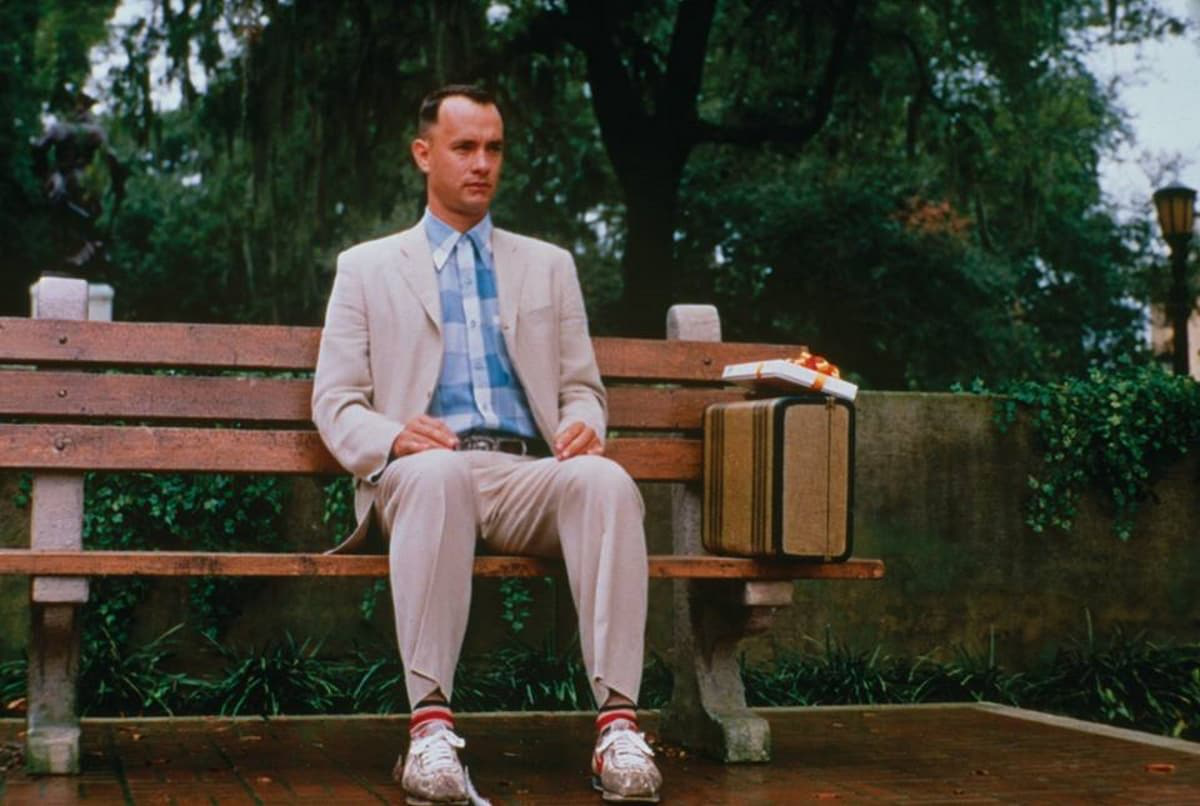

I see a man sitting on a bench with a backpack


In [0]:
!wget https://www.sorrisi.com/wp-content/uploads/2016/01/forrest-gump-facebook02.jpg
  
img = Image.open("forrest-gump-facebook02.jpg")
caption = caption_it(img)
display(img)
print("I see "+caption)

### Inception (2010)

--2019-09-09 18:03:12--  https://cdn.images.express.co.uk/img/dynamic/36/590x/Inception-ending-explained-1003919.jpg
Resolving cdn.images.express.co.uk (cdn.images.express.co.uk)... 13.224.2.15, 13.224.2.48, 13.224.2.103, ...
Connecting to cdn.images.express.co.uk (cdn.images.express.co.uk)|13.224.2.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26942 (26K) [image/jpeg]
Saving to: ‘Inception-ending-explained-1003919.jpg’

Inception-ending-ex 100%[===================>]  26.31K  --.-KB/s    in 0.1s    

2019-09-09 18:03:12 (211 KB/s) - ‘Inception-ending-explained-1003919.jpg’ saved [26942/26942]



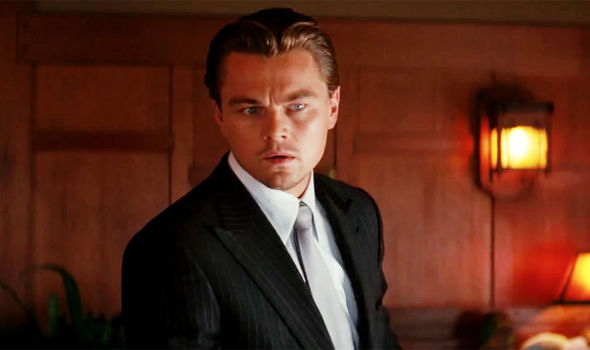

I see a man in a suit and tie standing next to a man


In [0]:
!wget https://cdn.images.express.co.uk/img/dynamic/36/590x/Inception-ending-explained-1003919.jpg
  
img = Image.open("Inception-ending-explained-1003919.jpg")
caption = caption_it(img)
display(img)
print("I see "+caption)

## Mr Robot (2015)

--2019-09-09 18:06:50--  https://www.indiewire.com/wp-content/uploads/2016/06/mr-robot1.jpg
Resolving www.indiewire.com (www.indiewire.com)... 192.0.66.2
Connecting to www.indiewire.com (www.indiewire.com)|192.0.66.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94929 (93K) [image/jpeg]
Saving to: ‘mr-robot1.jpg’

mr-robot1.jpg       100%[===================>]  92.70K  --.-KB/s    in 0.03s   

2019-09-09 18:06:50 (3.36 MB/s) - ‘mr-robot1.jpg’ saved [94929/94929]



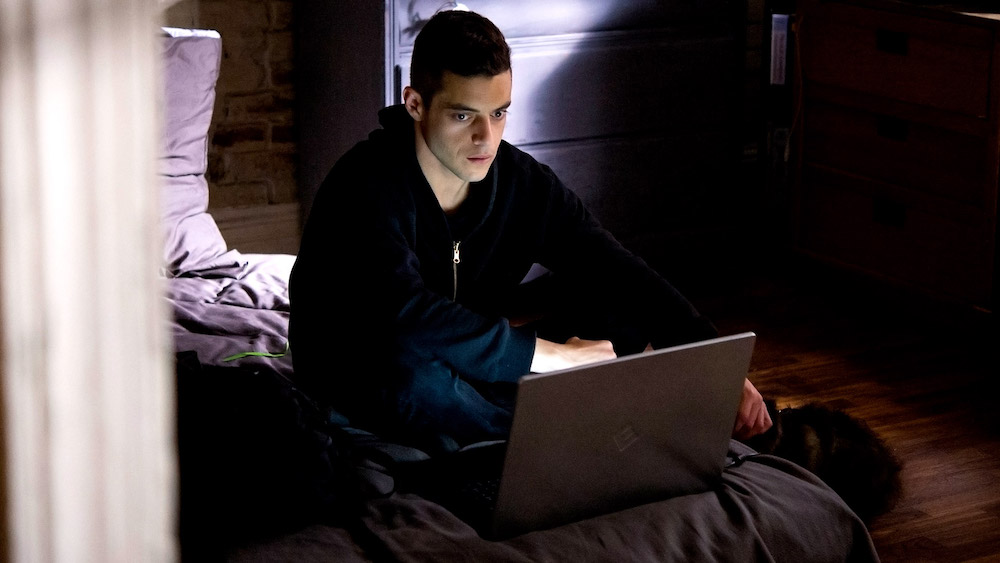

I see a man sitting on a couch with a laptop


In [0]:
!wget https://www.indiewire.com/wp-content/uploads/2016/06/mr-robot1.jpg
  
img = Image.open("mr-robot1.jpg")
caption = caption_it(img)
display(img)
print("I see "+caption)

### I Am Legend  (2007)

--2019-09-09 18:18:03--  https://www.elitereaders.net/wp-content/uploads/2018/09/i-am-legend.jpg
Resolving www.elitereaders.net (www.elitereaders.net)... 104.18.56.231, 104.18.57.231, 2606:4700:30::6812:39e7, ...
Connecting to www.elitereaders.net (www.elitereaders.net)|104.18.56.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74999 (73K) [image/jpeg]
Saving to: ‘i-am-legend.jpg’

i-am-legend.jpg     100%[===================>]  73.24K  --.-KB/s    in 0.01s   

2019-09-09 18:18:03 (7.01 MB/s) - ‘i-am-legend.jpg’ saved [74999/74999]



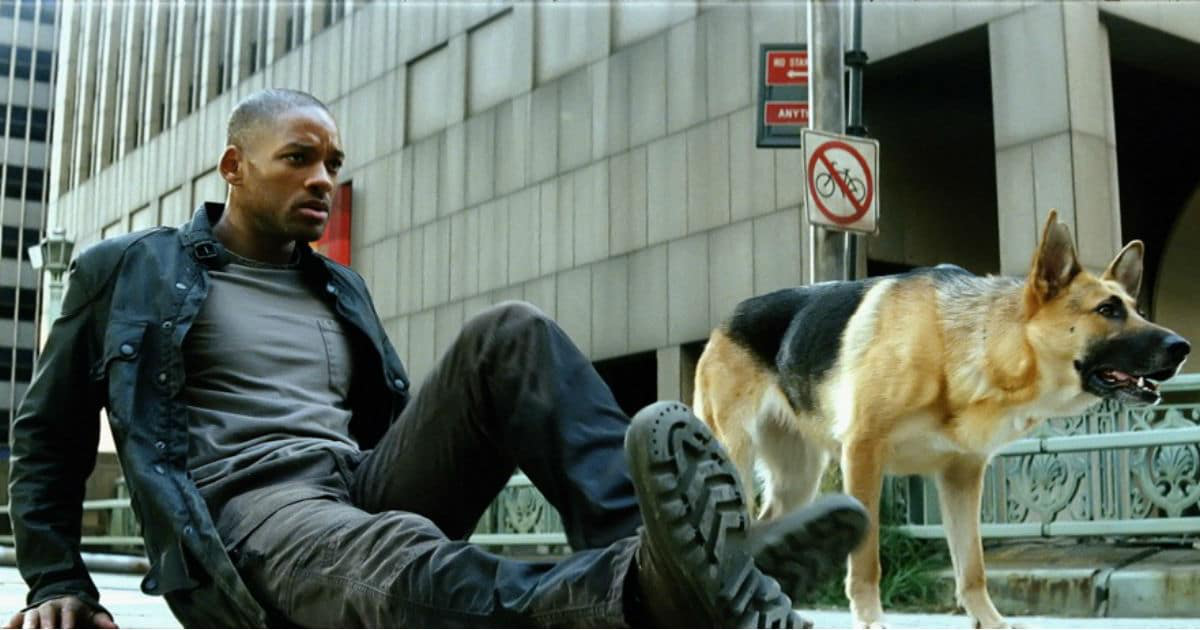

I see a man in a suit and tie standing next to a dog


In [0]:
!wget https://www.elitereaders.net/wp-content/uploads/2018/09/i-am-legend.jpg
  
img = Image.open("i-am-legend.jpg")
caption = caption_it(img)
display(img)
print("I see "+caption)

### Harry Potter and the philosopher's stone (2001)

--2019-09-09 18:24:59--  https://cdn.images.express.co.uk/img/dynamic/1/590x/Jacobite-train-576032.jpg
Resolving cdn.images.express.co.uk (cdn.images.express.co.uk)... 13.224.2.103, 13.224.2.126, 13.224.2.15, ...
Connecting to cdn.images.express.co.uk (cdn.images.express.co.uk)|13.224.2.103|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50153 (49K) [image/jpeg]
Saving to: ‘Jacobite-train-576032.jpg’

Jacobite-train-5760 100%[===================>]  48.98K   120KB/s    in 0.4s    

2019-09-09 18:25:00 (120 KB/s) - ‘Jacobite-train-576032.jpg’ saved [50153/50153]



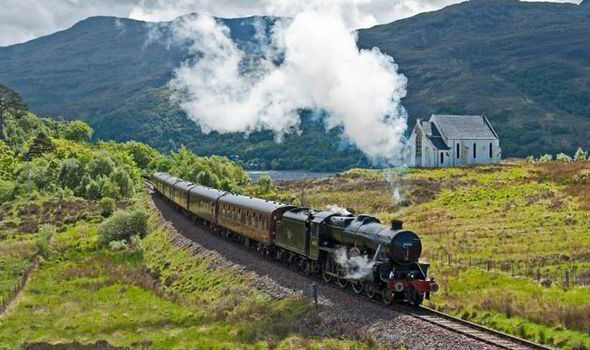

I see a train traveling down tracks near a forest


In [0]:
!wget https://cdn.images.express.co.uk/img/dynamic/1/590x/Jacobite-train-576032.jpg
  
img = Image.open("Jacobite-train-576032.jpg")
caption = caption_it(img)
display(img)
print("I see "+caption)

Our model works good enough, we are ready to deploy it ! To do we need to export Tokenizer, Image Encoder and Caption Model inside a *model* directory.

In [0]:
caption_model.save("model/caption_model.h5")
encode_mode.save("model/encode_model.h5")

with open("tokenizer.pickle","wb") as handle:
  pickle.dump(tokenizer ,handle)      

To learn how to deploy our model using Azure ML Services [look at this notebook](https://github.com/gfgullo/Pic2Speech/blob/master/jupyter%20notebooks/azure_model_deploy.ipynb).

# How to improve the Model
The problem of Image Captioning is one of the most challenging problem both in the fields of Natural Language Processing and Computer Vision. This notebook showed how to tackle this problem in a sophisticated way, however the model can vastly improved, the following are some suggestions to improve the model:
* Implementing an **Attention Mechanism (8)** as suggested in Show, Attend and Tell: Neural Image Caption Generation with Visual Attention by Xu et al (9).
* We train the model on nearly 90k images, which are too little for such problem, we could try increasing our dataset size collecting more samples from other datasets (like the [Flickr Image Dataset](https://www.kaggle.com/hsankesara/flickr-image-dataset)) or, even better but harder, manually captioning new images.
* And, of course, try to tune the hyperparameters and train the model for more steps.

<a id='references'></a>
## References
1. [Show and Tell: A Neural Image Caption Generator by Vinyals et al](https://arxiv.org/pdf/1411.4555.pdf)
2. [BLEU: a Method for Automatic Evaluation of Machine Translation by Papineni et al](https://www.aclweb.org/anthology/P02-1040)
3. [Rethinking the Inception Architecture for Computer Vision by Szegedy](https://arxiv.org/pdf/1512.00567.pdf)
4. [ImageNet: A Large-Scale Hierarchical Image Database by Deng](http://www.image-net.org/papers/imagenet_cvpr09.pdf)
5. [Distributed Representations of Words and Phrases
and their Compositionality by Mikolov et al](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
6. [GloVe: Global Vectors for Word Representation by Pennington et al](https://nlp.stanford.edu/pubs/glove.pdf)
7. [Adam: A Method for Stochastic Optimization by Kingma et al](https://arxiv.org/pdf/1412.6980.pdf)
8. [Attention is All you Need by Vaswani et al](https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf)
9. [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention by Xu et al](https://arxiv.org/pdf/1502.03044.pdf)